# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.302983,False,-2.534255
1,-0.394080,True,5.133011
2,-0.185101,False,-0.372530
3,-0.663932,True,4.849763
4,-0.332730,False,0.177322
...,...,...,...
995,1.577526,True,6.017716
996,-0.100380,False,-0.497787
997,-1.277537,False,-1.994353
998,-1.929935,False,-3.051819


<AxesSubplot:xlabel='v0'>

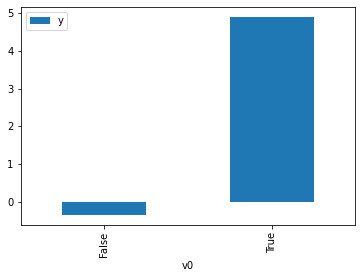

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

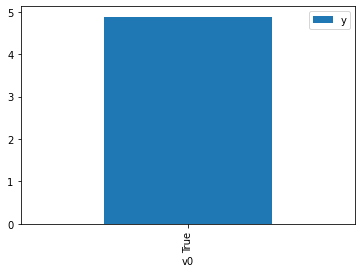

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.413411,False,-3.011550,0.718065,1.392632
1,-0.503486,False,-0.723673,0.758362,1.318631
2,-1.109065,False,-1.185229,0.927422,1.078257
3,-0.689446,False,-0.059338,0.828477,1.207035
4,-0.234609,False,0.550175,0.627225,1.594325
...,...,...,...,...,...
995,-1.052660,False,-2.134502,0.918113,1.089191
996,0.630880,False,-0.036196,0.184477,5.420726
997,-0.340382,False,0.629278,0.682560,1.465072
998,-1.706485,False,-2.135956,0.980789,1.019587


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.637850,True,6.357383,0.817942,1.222581
1,-0.339625,True,3.751875,0.317820,3.146436
2,-0.301255,True,4.089082,0.337412,2.963737
3,-0.794561,True,4.453677,0.139605,7.163087
4,0.690220,True,4.805532,0.835330,1.197132
...,...,...,...,...,...
995,0.920459,True,6.346192,0.896385,1.115592
996,-0.284072,True,6.897859,0.346376,2.887039
997,1.611058,True,6.970666,0.977220,1.023311
998,-0.607393,True,4.716431,0.200267,4.993341


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6738.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        21:13:40   Log-Likelihood:                         -1402.9
No. Observations:                1000   AIC:                                      2810.
Df Residuals:                     998   BIC:                                      2820.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8508      0.032     26.562      0.000       0.788       0.914
x2             5.0237      0.050    100.302      0.000       4.925       5.122
==============================================================================
Omnibus:                        0.299   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.861   Jarque-Bera (JB):                0.326
Skew:                           0.042   Prob(JB):                        0.849
Kurtosis:                       2.969   Cond. No.                         1.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""